# Week 4: Convolutional Neural Networks

We learned about feedforward neural networks over the last two weeks, along with most of the fundamental maths, algorithms, tricks, etc. that go into training them. Knowing how inputs propagate forward in the network, how gradients flow backwards and how weights get updated, we are now ready to release our imagination and create some deep neural networks that can do remarkable things. We will first focus on one of the most **powerful architectures**, the Convolutional Neural Network (CNN), which has completely revolutionalized image recognition in science and tech.

In [70]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist

## Exercises

The problem with feed forward images when classifying images is that the input layer looks at the whole image at once. Each input neuron thus becomes associated with a *specific* pixel, and as the network learns it may grow to expect a certain signal to emerge at that particular pixel. But if you imagine an image of a cat, features, like the whiskers, which make it cat-like, are not bound to a specific *place* in the image – they can be in the centre, top corner, or any other place.

CNNs solve this problem, with what's called *convolutional layers*. A convolutional input layer, for example, doesn't have a single weight for each input value. Instead, it has one or more much smaller *filters*, each one a set of input neurons (often $3 \times 3 \times d$ where $d$ is the depth of the input image (3 if it's an RGB image, 1 if its black and white)) that gets *convolved* across the input image to produce a new image, called an *activation map*. [Here](https://github.com/vdumoulin/conv_arithmetic) are some nice gifs that illustrate different ways one can convolve a weight matrix across an input image.

#### Pen and paper

To get your intuition for computations on input data in CNNs fine-tuned, a few small quizzes for you. First, we'll consider the size of the parameter space.

> **Ex. 4.1.1**: Imagine you have a CNN with just one convolutional layer with a single filter. All it does, is take an input image and produce an activation map. The dimensionality of the filter in your convolutional layer is $5 \times 5 \times 3$. How many weights (or *parameters*) are there in this model?
>
> *Hint*: Don't forget the bias!

Here's the formula for computing the size of the activation map resulting from a convolution. 
If you have a filter that is $F$ wide, your input image is $W_0$ wide, you are padding the edges by
$P$ pixels and your stride is $S$, the resulting image will have width/height:

$$ W_1 = \frac{W_0 - F + 2P}{S} + 1 $$

> **Ex. 4.1.2**: You input an image of dimensions $28 \times 28 \times 3$, use a padding of 2, a stride of 1,
and then slide your $5 \times 5 \times 3$ filter across the image. What is the dimensionality of the resulting activation map?

> **Ex. 4.1.3**: Let's say you now want to use a stride of 2, instead of 1. What problem does this immediately cause?
How can we solve it?

*Maxpooling* is a method used a lot in CNNs, which downsamples the size of an activation map. It is used primarily to reduce the amount of parameters and computations needed in the network, and to avoid overfitting. Here's an illustration of how it works:

![img](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

Typically, for each $2 \times 2$ square in your activation map, you pick the largest value in that square. You do this independently for every depth slice in your activation map.

**Note:** In Keras, the dimension of data is a little different from what you may expect. The first index,
indexes datapoints, the second and third are the dimensions of your images, and the last is number of channels. So if
you have a batch of data containing 100 datapoints, each one an RGB image (so 3 channels: red, green, blue)
with resolution $128 \times 128$, then the dimensionality of your input data is (100, 128, 128, 3).

> **Ex. 4.1.4**: Activation maps are the output of a convolution operation with a kernel. Given the (random generated) activation map below, what is the corresponding activation map after maxpooling ($2 \times 2$ filter, stride 2)? Run it through a Keras maxpooling layer ([check out the docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)), and report the dimensionality.

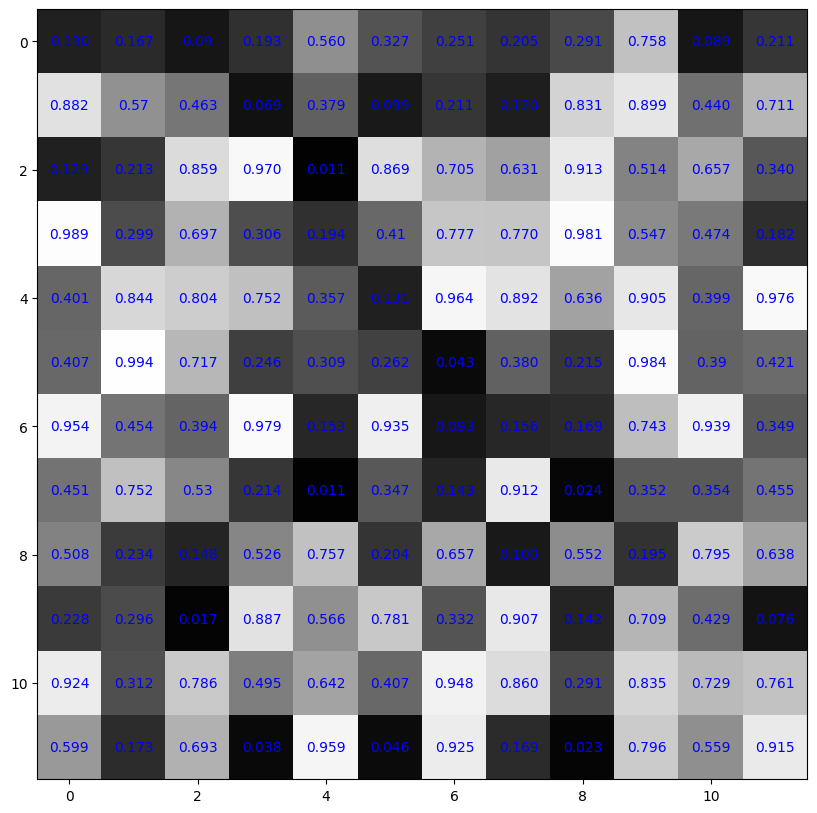

In [71]:
# Random generating an activation map 'a' with dimension 
# [number of datapoints (images) = 1,
#  number of rows = 12,
#  number of cols = 12,
#  number of channels = 1]
a = np.random.random(size=(1, 12, 12, 1))
activation_map = keras.backend.variable(a)

# Let us plot the output
fig, ax = plt.subplots(figsize=[10,10])
im = ax.imshow(activation_map[0,:,:,0], cmap='gray', vmin=0, vmax=1)

for i in range(12):
    for j in range(12):
        text = ax.text(j, i, np.format_float_positional(activation_map[0,i,j,0], precision=3),
                       ha="center", va="center", color="blue")


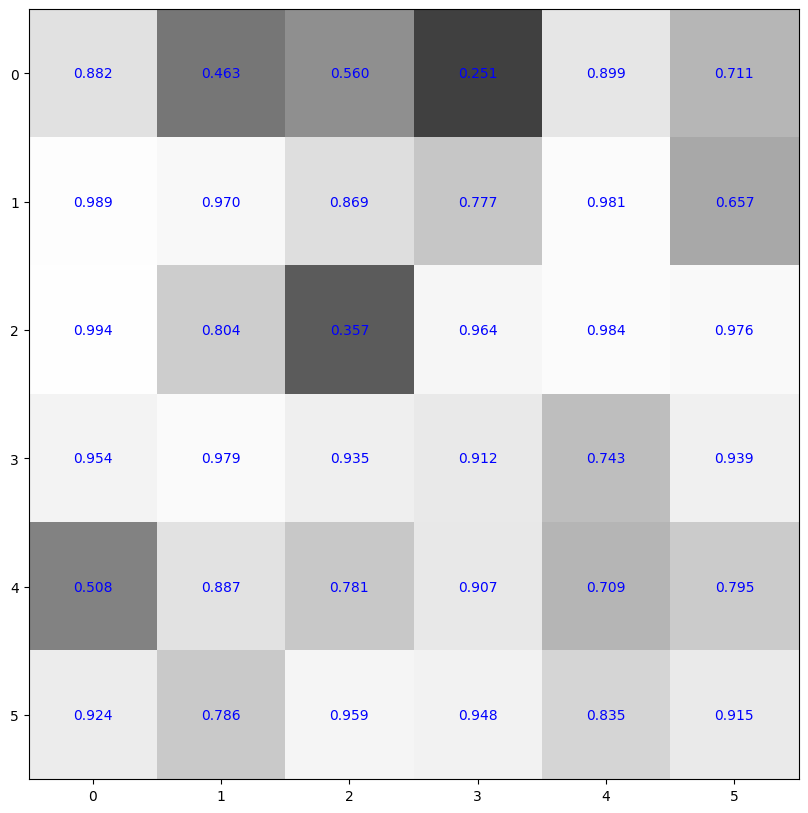

In [72]:
pool = MaxPooling2D(
    pool_size=(2, 2),
    strides=2,
    padding='valid',
    data_format=None,
    name=None,
)
processed = pool(a)
activation_map = keras.backend.variable(processed)
# Let us plot the output
fig, ax = plt.subplots(figsize=[10,10])
im = ax.imshow(activation_map[0,:,:,0], cmap='gray', vmin=0, vmax=1)

for i in range(6):
    for j in range(6):
        text = ax.text(j, i, np.format_float_positional(activation_map[0,i,j,0], precision=3),
                       ha="center", va="center", color="blue")

we can see that the values are much larger than those of the previous layers, and we don't see any super dark pixels anymore. If we were do the same process with min pool, we would see the exact opposite picture, with lots of black and very little white.

#### CNNs in Keras

For example sake, I've implemented a single conv. layer neural network Keras below.

In [73]:
model = Sequential([
    Conv2D(filters=10, kernel_size=(3,3), strides=(1, 1), input_shape=[28,28,1], padding='valid'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(10)
])

In the following exercise you will use the MNIST dataset again. In the cell below we've written some code to prepare it somewhat. Really try to understand what's happening here.

In [92]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data to have a color-channel dimension (even though it's grayscale)
rows, cols = x_train.shape[-2:]
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)

# Convert pixel intensities to values between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
    
# Convert target vectors to one-hot encoding
num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

> **Ex. 4.1.5**: Implement Nielsen's [last convolutional neural network](http://neuralnetworksanddeeplearning.com/chap6.html#problem_437600)
(the one with *two convolutional layers + dropout*), and score an accuracy higher than 98% on the test data. It doesn't have to be
fully identical, but his solution is good, so getting close is an easy way to score a high accuracy.
>
> *Hint:* [here](https://keras.io/examples/vision/mnist_convnet/) is an example of a CNN in Keras. Not to copy line by line, but just to have a reference for how it's done, remember you want something similar to Nielsen's.

In [104]:
model = Sequential([
        # Conv2D(filters=10, kernel_size=(3,3), strides=(1, 1), input_shape=[28,28,1], padding='valid')
        Conv2D(input_shape=[28,28,1], 
                      kernel_size=(5, 5), 
                      padding='valid',
                      filters=20),
        MaxPooling2D(
                    pool_size=(2, 2),
                    strides=2,
                    padding='valid',
                    data_format=None,
                    name=None,
                ),
        Conv2D(input_shape=[12,12,1], 
                      kernel_size=(5, 5), 
                      padding='valid',
                      filters=20),
        # MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(32, activation = 'relu'),
        Dense(32, activation = 'relu'),
        Dense(10, activation = 'softmax')
        # FullyConnectedLayer(n_in=40*4*4, n_out=100, activation_fn=ReLU),
        # FullyConnectedLayer(n_in=100, n_out=100, activation_fn=ReLU),
])


In [105]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# let's see what the model "looks" like
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 24, 24, 20)     │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 12, 12, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 20)       │        10,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,918 (206.71 KB)

 Trainable params: 52,918 (206.71 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
H = model.fit(x_train, y_train, epochs=8, batch_size=128)

Epoch 1/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7946 - loss: 0.6575
Epoch 2/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9634 - loss: 0.1225
Epoch 3/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9793 - loss: 0.0696
Epoch 4/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9833 - loss: 0.0545
Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9870 - loss: 0.0438
Epoch 6/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9886 - loss: 0.0362
Epoch 7/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9882 - loss: 0.0354
Epoch 8/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9895 - loss: 0.0327


In [108]:
score = model.evaluate(x_test, y_test, batch_size=100)
print(score[0])
print(score[1])

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9839 - loss: 0.0509
0.041905149817466736
0.9871000051498413


The MNIST dataset is a great benchmark because it allows us to directly measure the performance of a neural
network against the human eye. But often, the association between datapoint and label is not as clear, yet we
still want to do prediction.